In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

In [2]:
DEBUG = True

if DEBUG:
    NROWS = 100000
else:
    NROWS = None

In [3]:
%%time

train = pd.read_csv('../input/porto-seguros-safe-driver-prediction-dataset/train.csv', nrows = NROWS)
test = pd.read_csv('../input/porto-seguros-safe-driver-prediction-dataset/test.csv', nrows = NROWS)

CPU times: user 662 ms, sys: 147 ms, total: 809 ms
Wall time: 1.49 s


In [4]:
train.shape

(100000, 59)

In [5]:
cat_cols = [col for col in train.columns if 'cat' in col]
cat_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [6]:
train[cat_cols[0]].value_counts()

 1    72801
 2    20504
 3     4777
 4     1887
-1       31
Name: ps_ind_02_cat, dtype: int64

In [7]:
train.drop_duplicates()
train.shape

(100000, 59)

In [8]:
data = []
for f in train.columns:
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
        
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    keep = True
    if f == 'id':
        keep = 'False'
        
    dtype = train[f].dtype
    
    f_dict = {
        'varname' : f,
        'role' : role,
        'level' : level,
        'keep' : keep,
        'dtype' : dtype
    }
    data.append(f_dict)
   

In [9]:
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace = True)

In [10]:
meta.loc[(meta.level == 'nominal') & (meta.keep)].index

Index(['id', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [11]:
pd.DataFrame({'count': meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


In [12]:
v = meta.loc[(meta.level =='interval') & meta.keep].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.610932,0.440689,0.549986,0.379749,0.812314,0.277426,3.065537,0.449908,0.448632,0.450141
std,0.288378,0.404073,0.795653,0.058258,0.222757,0.354939,0.733315,0.286854,0.286697,0.287042
min,0.000000,0.000000,-1.000000,0.141421,0.313241,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.524404,0.316228,0.670882,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.721110,0.374166,0.765541,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.003120,0.400000,0.905573,0.396989,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,3.490791,1.264911,3.253698,0.636396,3.741657,0.900000,0.900000,0.900000


In [13]:
v = meta.loc[(meta.level == 'ordinal') & meta.keep].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.903690,4.434040,0.012610,7.320070,2.344030,2.367400,1.885610,7.692350,2.996860,9.221540,2.334880,8.419470,5.449950,1.444620,2.874080,7.525540
std,1.983783,2.700789,0.129735,3.552114,0.833991,1.117448,1.135517,1.336331,1.412979,1.462984,1.247578,2.906844,2.336029,1.204154,1.694029,2.750859
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,23.000000,19.000000,10.000000,12.000000,22.000000


In [14]:
v  = meta.loc[(meta.level == 'binary') & meta.keep].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.03671,0.393240,0.254790,0.164800,0.18717,0.000410,0.001960,0.009260,0.00098,0.660520,0.121640,0.151670,0.122720,0.630440,0.555720,0.286890,0.350700,0.153550
std,0.18805,0.488472,0.435745,0.371002,0.39005,0.020244,0.044229,0.095783,0.03129,0.473535,0.326871,0.358703,0.328117,0.482688,0.496888,0.452312,0.477192,0.360519
min,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.00000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
desired_apriori = 0.1

idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

In [16]:
undersampling_rate = ((1-desired_apriori)*nb_1)/((nb_0 * desired_apriori))

In [17]:
undersampled_nb_0 = int(undersampling_rate*nb_0)

In [18]:
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

Rate to undersample records with target=0: 0.3429808261271268
Number of records with target=0 after undersampling: 33039


In [19]:
undersampled_idx = shuffle(idx_0, random_state = 37, n_samples = undersampled_nb_0)

In [20]:
idx_list = list(undersampled_idx) + list(idx_1)

In [21]:
train = train.loc[idx_list].reset_index(drop = True)

In [22]:
vars_with_missing  = []

for f in train.columns:
    missings = train.loc[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 14 records (0.04%) with missing values
Variable ps_ind_04_cat has 9 records (0.02%) with missing values
Variable ps_ind_05_cat has 374 records (1.02%) with missing values
Variable ps_reg_03 has 6546 records (17.83%) with missing values
Variable ps_car_01_cat has 8 records (0.02%) with missing values
Variable ps_car_03_cat has 25167 records (68.56%) with missing values
Variable ps_car_05_cat has 16208 records (44.15%) with missing values
Variable ps_car_07_cat has 715 records (1.95%) with missing values
Variable ps_car_09_cat has 36 records (0.10%) with missing values
Variable ps_car_14 has 2552 records (6.95%) with missing values
In total, there are 10 variables with missing values


In [23]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace = True, axis = 1)
meta.loc[(vars_to_drop), 'keep'] = False

In [24]:
mean_imp = SimpleImputer(missing_values = -1, strategy = 'mean')
mode_imp = SimpleImputer(missing_values = -1, strategy = 'most_frequent')

In [25]:
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

In [26]:
v = meta[(meta.level == 'nominal') & meta.keep].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('variable {} has {} distinct val'.format(f, dist_values))

variable id has 36710 distinct val
variable ps_ind_02_cat has 5 distinct val
variable ps_ind_04_cat has 3 distinct val
variable ps_ind_05_cat has 8 distinct val
variable ps_car_01_cat has 13 distinct val
variable ps_car_02_cat has 2 distinct val
variable ps_car_04_cat has 10 distinct val
variable ps_car_06_cat has 18 distinct val
variable ps_car_07_cat has 3 distinct val
variable ps_car_08_cat has 2 distinct val
variable ps_car_09_cat has 6 distinct val
variable ps_car_10_cat has 3 distinct val
variable ps_car_11_cat has 104 distinct val


In [27]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [28]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

In [29]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

In [30]:
def corr_heatmap(v):
    correlations = train[v].corr()
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, cmap = cmap, vmax = 1.0, center=0, fmt='.2f',
               square = True, linewidths = .5, annot= True, cbar_kws = {'shrink':.75})
    plt.show();
   

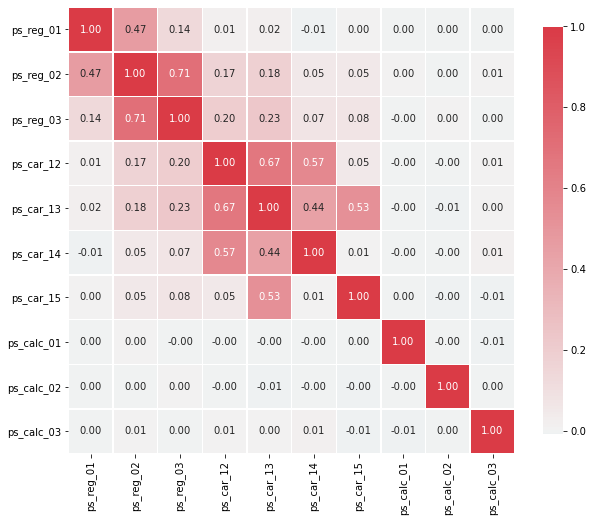

In [31]:
 
v = meta[(meta.level == 'interval') & meta.keep].index
corr_heatmap(v)

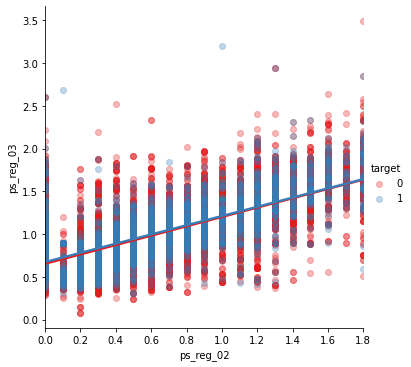

In [32]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data = train, hue='target', palette = 'Set1', scatter_kws={'alpha':0.3})
plt.show()

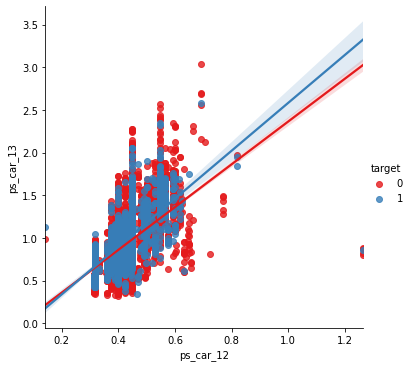

In [33]:
sns.lmplot(x = 'ps_car_12', y='ps_car_13', data=train, hue = 'target', palette='Set1')
plt.show()

In [34]:
v = meta.loc[(meta.level == 'nominal') & (meta.keep)].index
print('before onehot {}'.format(train.shape[1]))

before onehot 57


In [35]:
temp = pd.get_dummies(train, columns=v, drop_first=True)

In [36]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree = 2, interaction_only = False, include_bias=False)
interactions = pd.DataFrame(data = poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)
print('before {}'.format(train.shape[1]))
train = pd.concat([train, interactions], axis =1)
print('before {}'.format(train.shape[1]))

before 57
before 112


In [37]:
selector = VarianceThreshold(threshold = .01)
selector.fit(train.drop(['id', 'target'], axis=1))

VarianceThreshold(threshold=0.01)

In [38]:
f = np.vectorize(lambda x:not x)

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]

In [39]:
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

11 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


In [40]:
x_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_label = x_train.columns

In [41]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 0, n_jobs = -1)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)

In [42]:
importances = rf.feature_importances_

In [43]:
indices = np.argsort(rf.feature_importances_)[::-1]

In [44]:
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_label[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.024051
 2) ps_reg_03 ps_car_13            0.017457
 3) ps_car_12 ps_car_13            0.017347
 4) ps_car_13                      0.017178
 5) ps_car_13 ps_car_14            0.017134
 6) ps_car_13^2                    0.017073
 7) ps_reg_01 ps_car_13            0.016854
 8) ps_car_13 ps_car_15            0.016677
 9) ps_reg_03 ps_car_14            0.016425
10) ps_reg_03 ps_car_12            0.016235
11) ps_car_14 ps_car_15            0.015988
12) ps_reg_03 ps_car_15            0.015324
13) ps_car_13 ps_calc_03           0.015233
14) ps_reg_01 ps_car_14            0.014946
15) ps_car_13 ps_calc_02           0.014945
16) ps_car_13 ps_calc_01           0.014820
17) ps_reg_03                      0.014592
18) ps_reg_01 ps_reg_03            0.014486
19) ps_reg_03^2                    0.014277
20) ps_calc_14                     0.014236
21) ps_reg_02 ps_car_13            0.014236
22) ps_reg_03 ps_calc_03           0.013981
23) ps_car_14 ps_calc_03        

In [45]:
sfm = SelectFromModel(rf, threshold = 'median', prefit = True)
print('Num of featu before selec {}'.format(x_train.shape[1]))

Num of featu before selec 110


In [46]:
n_features = sfm.transform(x_train).shape[1]
print('num after {}'.format(n_features))
selected_vars = list(feat_label[sfm.get_support()])

num after 55


In [47]:
train = train[selected_vars + ['target']]

In [48]:
scaler = StandardScaler()

In [49]:
scaler.fit_transform(train.drop(['target'], axis=1))

array([[ 1.31564127e+00, -1.48636895e+00,  5.06114991e-01, ...,
        -2.57015529e-01,  1.24510598e+00,  3.44837377e-01],
       [ 5.75873919e-01,  1.59948350e+00, -6.99658455e-16, ...,
         7.42649668e-01, -1.00984669e+00, -1.00258466e+00],
       [-9.03660782e-01,  7.57887381e-01, -7.20795594e-01, ...,
        -1.07065749e-01, -7.09186333e-01, -4.03730420e-01],
       ...,
       [-1.64342813e+00, -8.37087437e-02,  1.32713744e+00, ...,
        -7.06864867e-01,  1.92794733e-01, -8.02966579e-01],
       [ 5.75873919e-01, -6.44772827e-01, -1.12458460e+00, ...,
        -7.09922955e-03, -4.08525978e-01, -2.54016861e-01],
       [-1.27354446e+00,  4.77355339e-01,  1.35684272e+00, ...,
        -1.00676443e+00,  2.42904792e-01, -1.00258466e+00]])